In [28]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
from collections import Counter
from itertools import product, combinations
from sklearn.datasets import load_svmlight_file
from sklearn.manifold import TSNE

In [5]:
DATASETS = ["20ng", "acm", "webkb", "reut"]

ALGORITHMS = ["centroide", "gbm", "knn", "lr", "rf", "svm", "bert"]

In [6]:
def load_preds_2(DATASETS, ALGORITHMS, preds_path="data/preds.pickle"):
    

    if os.path.exists(preds_path):
        with open(preds_path, 'rb') as handle:
            print("LOADING PRE PROCESSED PREDS.")
            return pickle.load(handle)
    
    print("LOADING PREDS FROM SCRATCH")
    d_preds = {}
    for dset, alg, fold in tqdm(product(DATASETS, ALGORITHMS, np.arange(10))):
        
        if dset not in d_preds:
            d_preds[dset] = {}
        
        if alg == "bert":
            j = f"/home/claudiovaliense/projetos/kaggle/{dset}_bert{fold}_pred.json"
        else:
            j = f"/home/claudiovaliense/projetos/kaggle/{dset}_bert{fold}_{alg}"

        with open(j, 'r') as fd:
            try:
                y_pred = json.load(fd)["y_pred"]
            except:
                print(j)
                return False

        if alg not in d_preds[dset]:
            d_preds[dset][alg] = y_pred
        else:
            d_preds[dset][alg] = np.hstack([d_preds[dset][alg], y_pred])
    
    with open(preds_path, 'wb') as handle:
        pickle.dump(d_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return d_preds


In [7]:
def load_preds(DATASETS, ALGORITHMS, preds_path="data/preds.pickle"):
    

    if os.path.exists(preds_path):
        with open(preds_path, 'rb') as handle:
            print("LOADING PRE PROCESSED PREDS.")
            return pickle.load(handle)
    
    print("LOADING PREDS FROM SCRATCH")
    d_preds = {}
    for dset, alg, fold in tqdm(product(DATASETS, ALGORITHMS, np.arange(10))):
        
        if dset not in d_preds:
            d_preds[dset] = {}
        
        if alg != "bert":
            j = f"/home/claudiovaliense/projetos/kaggle/{dset}_bert{fold}_{alg}"
            with open(j, 'r') as fd:
                try:
                    y_pred = json.load(fd)["y_pred"]
                except:
                    print(j)
                    return False
        else:
            file_path = f"../stacking_text_classification/data/meta_layer_input/{dset}/10_folds/bert/{fold}/test.npz"
            load = np.load(file_path, allow_pickle=True)
            y_pred = load["X_test"].argmax(axis=1)
        
        if alg not in d_preds[dset]:
            d_preds[dset][alg] = y_pred
        else:
            d_preds[dset][alg] = np.hstack([d_preds[dset][alg], y_pred])
    
    with open(preds_path, 'wb') as handle:
        pickle.dump(d_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return d_preds


In [8]:
d_preds = load_preds(DATASETS, ALGORITHMS)

LOADING PRE PROCESSED PREDS.


In [9]:
def all_against_all(preds, df):

    rates = []
    for clf1, clf2 in combinations(preds.keys(), 2):

        p1 = preds[clf1]
        p2 = preds[clf2]

        # Looking at where the classifiers predicted equal.
        total_common = np.sum(p1 == p2) / p1.shape[0]
        total_common = np.around(total_common * 100, decimals=2)

        hits_p1 = df.classes.values == p1
        hits_p2 = df.classes.values == p2

        # Looking at where the classifiers predicted right and equal.
        common_hits = np.sum(hits_p1 * hits_p2) / p1.shape[0]
        common_hits = np.around(common_hits * 100, decimals=2)

        # Looking at where the classifiers predicted wrong and equal.
        misses_p1 = np.where(df.classes.values != p1)[0]
        misses_p2 = np.where(df.classes.values != p2)[0]
        common_misses = np.intersect1d(misses_p1, misses_p2).shape[0]
        union = np.union1d(misses_p1, misses_p2).shape[0]

        global_misses = np.around((common_misses / p1.shape[0]) * 100, decimals=2)
        local_misses = np.around((common_misses / union) * 100, decimals=2)

        rates.append([f"{clf1}-{clf2}", total_common, common_hits, global_misses, local_misses])

    return pd.DataFrame(rates, columns=["Pair", "Common Prediction Rate", "Common Hists Rate", "Commom Misses Rate (Global)", "Commom Misses Rate (Local)"])

In [10]:
pd_datasets = {}
for dset in DATASETS:
    pd_datasets[dset] = pd.read_csv(f"../stacking/output/datasets/{dset}.csv")

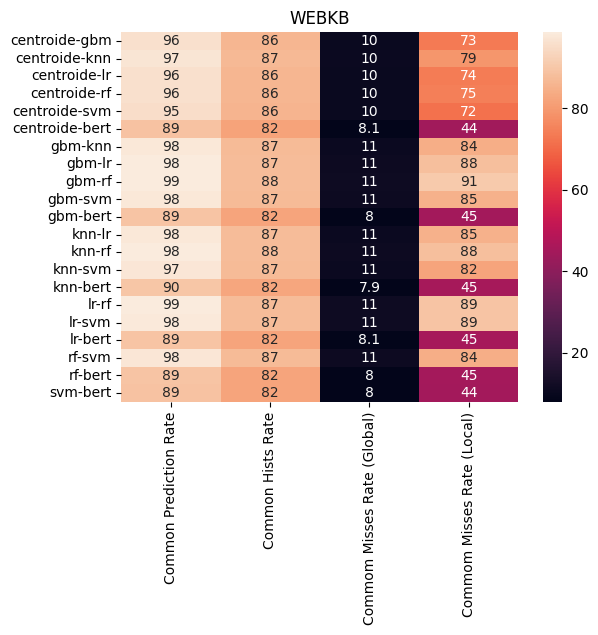

In [11]:
def heatmap(dset, d_preds, pd_datasets):
    
    df = pd_datasets[dset]
    rates = all_against_all(d_preds[dset], df)
    ax = plt.axes()
    heatmap = sbn.heatmap(rates.drop(columns=["Pair"]), yticklabels=rates.Pair.values, annot=True)
    _ = ax.set_title(dset.upper())

heatmap("webkb", d_preds, pd_datasets)

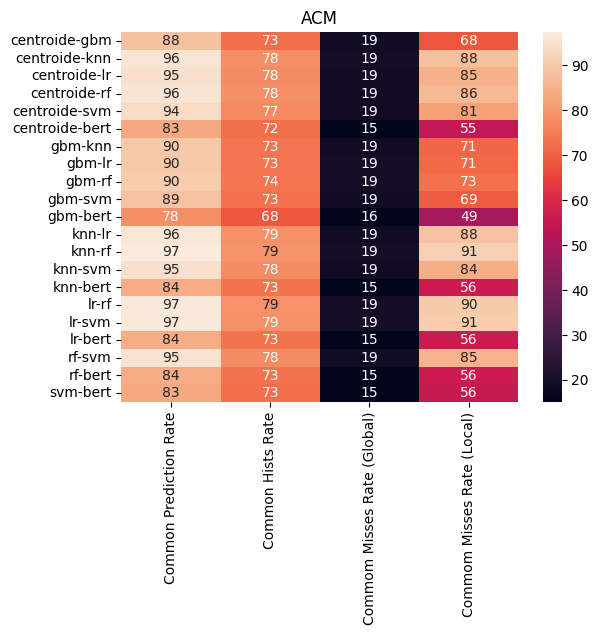

In [12]:
heatmap("acm", d_preds, pd_datasets)

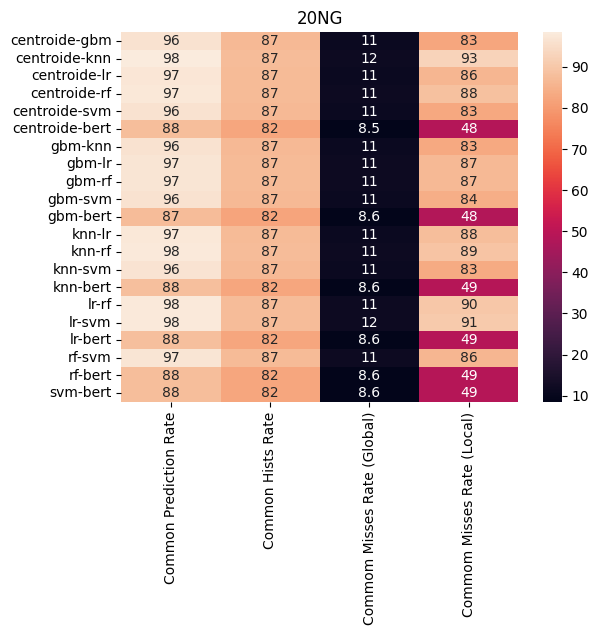

In [13]:
heatmap("20ng", d_preds, pd_datasets)

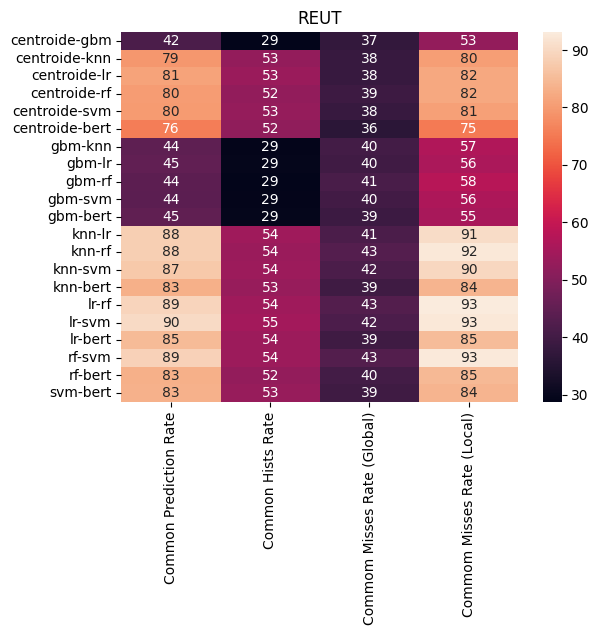

In [14]:
heatmap("reut", d_preds, pd_datasets)

In [15]:
global_agree = {}
hits_agree = {}
for dset in DATASETS:
    global_agree[dset] = []
    df = pd_datasets[dset]
    preds = pd.DataFrame(d_preds[dset]).values
    for idx in np.arange(preds.shape[0]):
        counts = Counter(preds[idx])
        agree_size = counts.most_common()[0][1]
        global_agree[dset].append(agree_size)
    hits_agree[dset] = np.sum(preds == df.classes.values[:, None], axis=1)


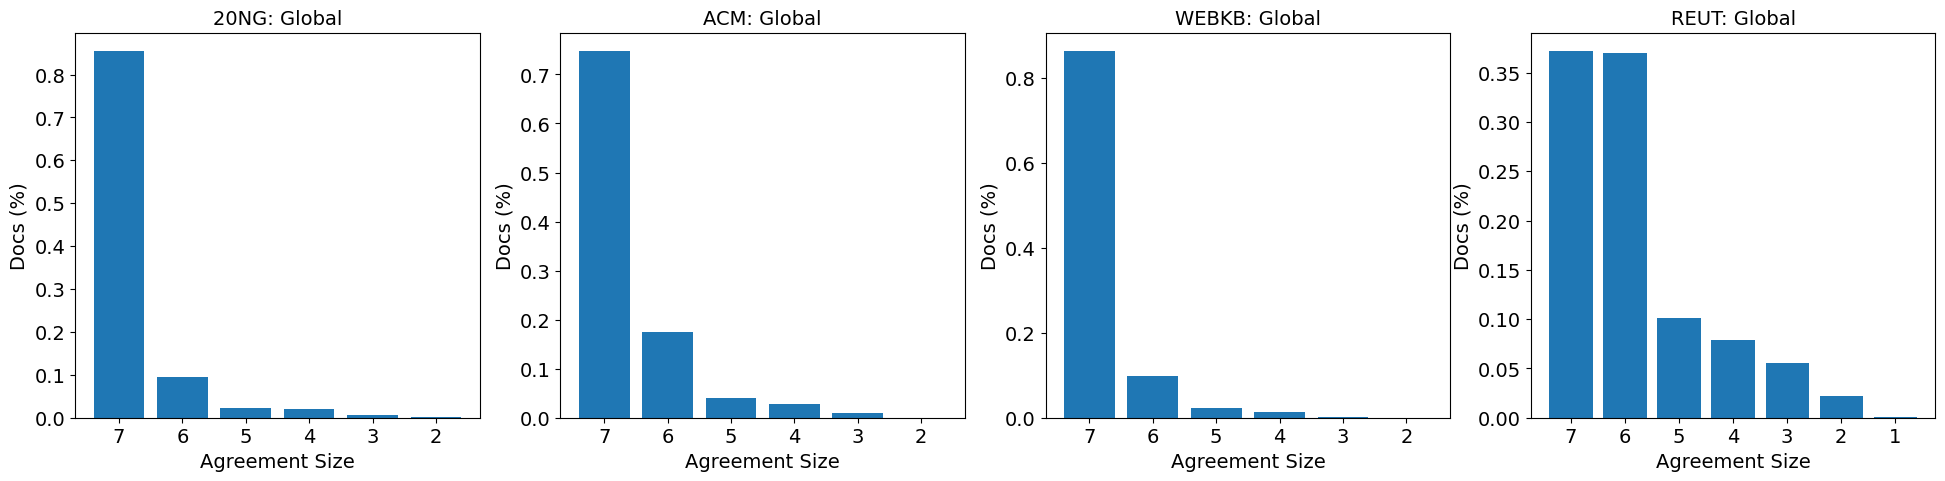

In [16]:
def plot_dists(dset_values, xl="Agreement Size", yl="Docs (%)", kind=None):
    plt.figure(figsize=(24, 5))
    ld = len(DATASETS)
    for plot_idx, dset in enumerate(DATASETS):
        counts = pd.Series(dset_values[dset]).value_counts(normalize=True)
        keys = sorted(list(counts.keys()), reverse=True)
        values = [ counts[key] for key in keys ]
        plt.subplot(1, ld, plot_idx + 1)
        x = np.arange(len(values))
        plt.bar(x, values)
        plt.xticks(ticks=x, labels=keys, fontsize=14)
        plt.yticks(fontsize=14)

        plt.title(f"{dset.upper()}: {kind}", fontsize=14)
        plt.xlabel(xlabel=xl, fontsize=14)
        plt.ylabel(yl, fontsize=14)
    #plt.tight_layout()
kind = "Global"

plot_dists(global_agree, kind="Global")

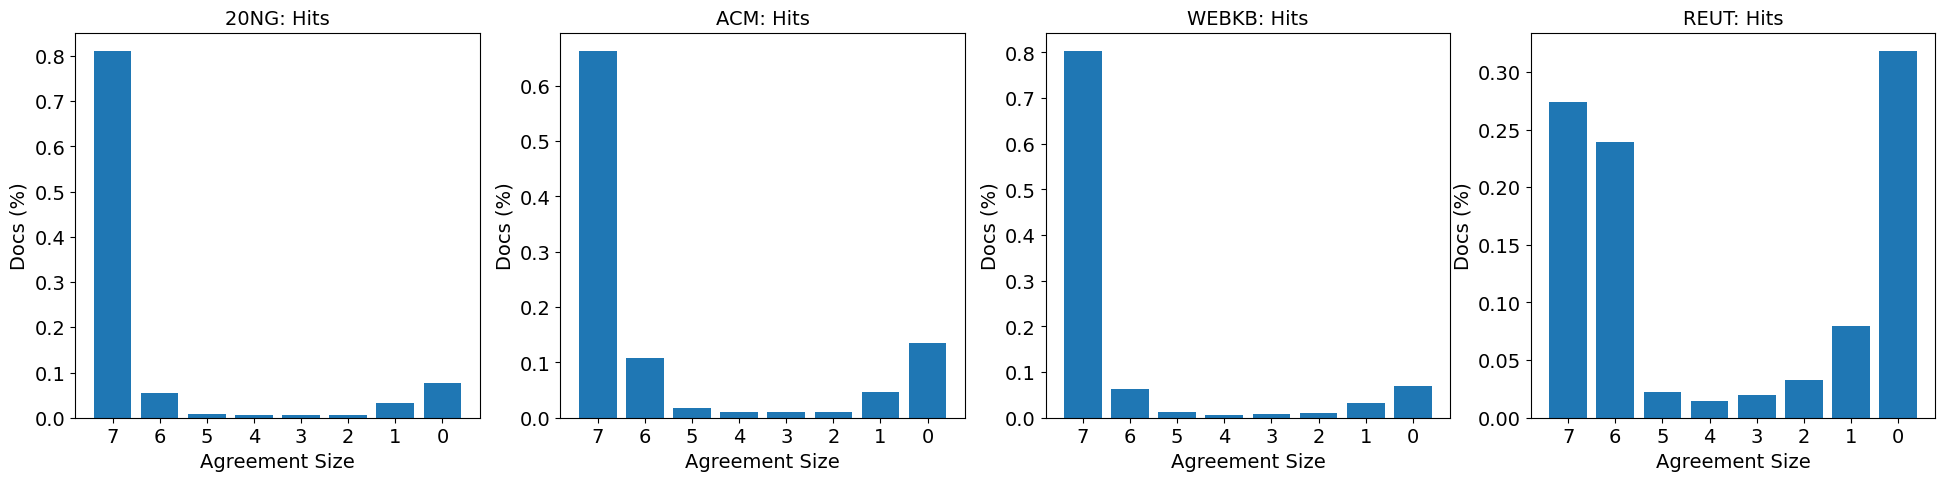

In [17]:
plot_dists(hits_agree, kind="Hits")

In [18]:
orig_stacking = {}
pred_cols = [ col for col in df.columns if col.find("_y_pred") > 0 ]
for dset in DATASETS:
    orig_stacking[dset] = {}
    df = pd_datasets[dset]
    preds = df[pred_cols].values
    labels = df.classes.values
    hits = np.sum(preds == df.classes.values[:, None], axis=1)
    orig_stacking[dset]["hits"] = hits
    orig_stacking[dset]["cout_hits"] = np.sum(hits > 0) / df.shape[0]

In [19]:
bert_stacking = {}
for dset in DATASETS:
    preds = pd.DataFrame(d_preds[dset]).values
    y_true = pd.read_csv(f"../stacking/output/datasets/{dset}.csv").classes.values
    hits = np.sum(preds == y_true[:, None], axis=1)
    bert_stacking[dset] = np.sum( hits > 0 ) / preds.shape[0]


In [20]:
def cdf(dist):

    counts = pd.Series(dist).value_counts(normalize=True)
    keys = list(counts.keys())
    keys.sort(reverse=True)
    #total = np.sum(dist)
    acc = 0
    cdf_values = []
    for key in keys:
        acc += counts[key]
        cdf_values.append(acc)
    
    return cdf_values, keys

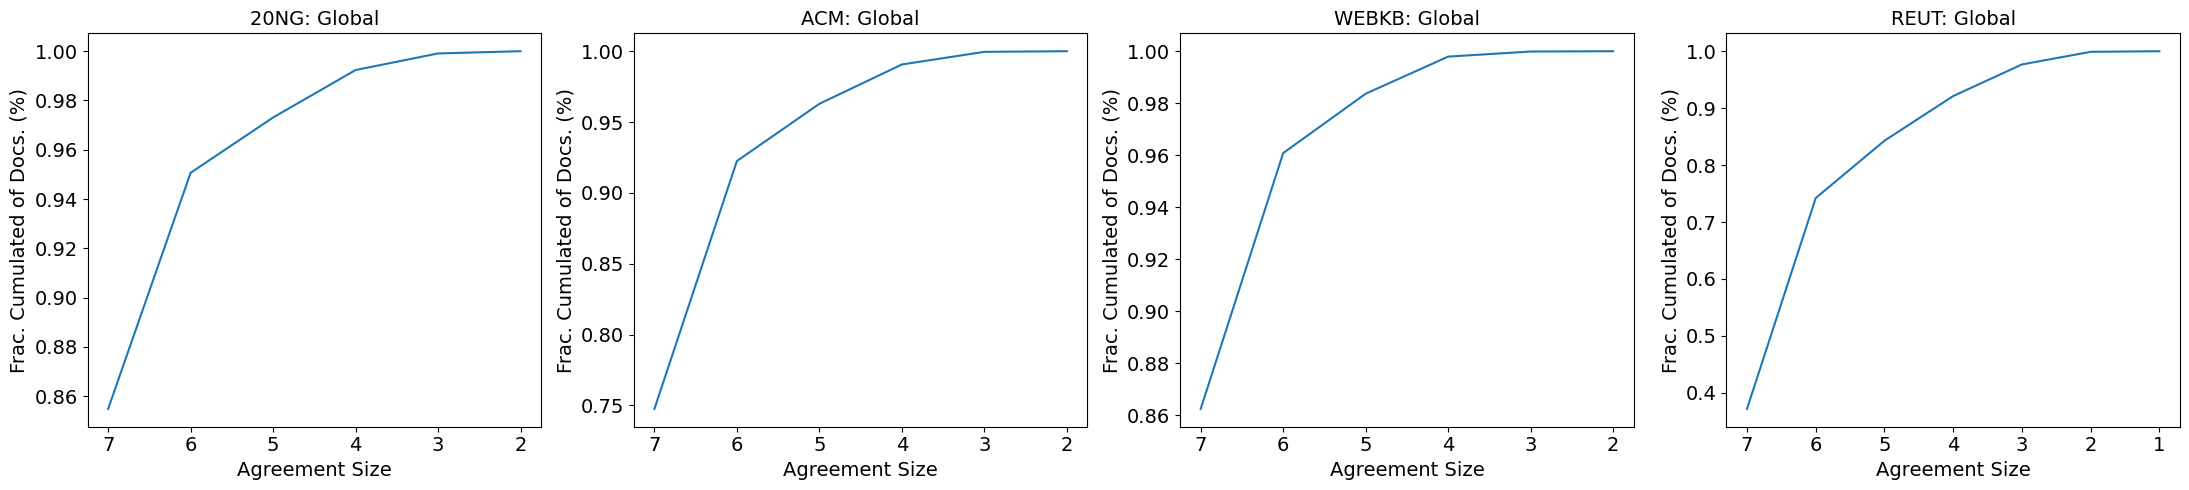

In [21]:
def plot_cdfs(dset_values, xl="Agreement Size", kind=None, bert_stacking=None, orig_stacking=None):
    plt.figure(figsize=(22, 5))
    ld = len(DATASETS)
    for plot_idx, dset in enumerate(DATASETS):
        cdf_values, keys = cdf(dset_values[dset])
        plt.subplot(1, ld, plot_idx + 1)
        x = np.arange(len(cdf_values))
        plt.plot(x, cdf_values)
        plt.xticks(ticks=x, labels=keys, fontsize=14)
        plt.yticks(fontsize=14)

        plt.title(f"{dset.upper()}: {kind}", fontsize=14)
        plt.xlabel(xlabel=xl, fontsize=14)
        plt.ylabel("Frac. Cumulated of Docs. (%)", fontsize=14)

        if bert_stacking is not None:
            plt.axhline(y=bert_stacking[dset], label='Bert Stacking', color="red")
        if orig_stacking is not None:
            plt.axhline(y=orig_stacking[dset]["cout_hits"], label='Original Stacking', color="Blue")
            plt.legend()
            
    plt.tight_layout()
kind = "Global"

plot_cdfs(global_agree, kind="Global")

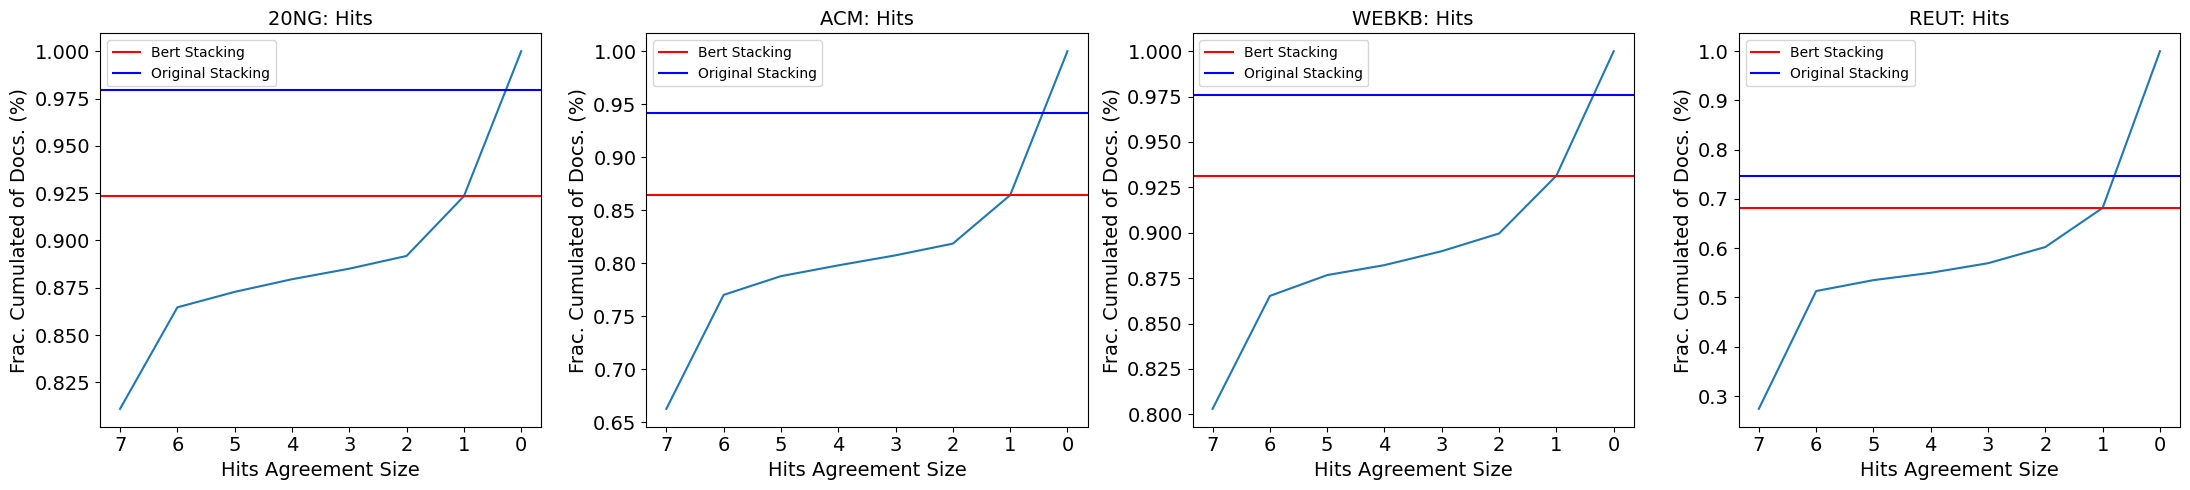

In [22]:
plot_cdfs(hits_agree, "Hits Agreement Size", "Hits", bert_stacking=bert_stacking, orig_stacking=orig_stacking)

In [23]:
def load_bert_reps():
    bert_reps = {}
    for dset in DATASETS:
        reps_list = []
        for fold in np.arange(10):
            file_path = f"../data/reps/split_10_with_val/bert_base/fine_tuning/{dset}/{fold}/test.npy"
            fold_rep = np.load(file_path, allow_pickle=True)
            reps_list.append(fold_rep)
        bert_reps[dset] = np.vstack(reps_list)
    
    return bert_reps

bert_reps = load_bert_reps()

In [24]:
def scatter_plot(tsne, hits):
    
    for group in range(2, -1, -1):
        x = tsne[:, 0]
        y = tsne[:, 1]
        xg = x[hits == group]
        yg = y[hits == group]
        if group < 2:
            label = f"#Hits: {group}"
        else:
            label = f"#Hits: > 1"
        plt.scatter(xg, yg, label=label, marker='.')#, edgecolors="black")
    plt.legend()

In [25]:
d_tsne = {}
for dset in tqdm(DATASETS):

    tsne_dir = f"data/tsne/{dset}/"
    tsne_path = f"{tsne_dir}/tsne.pickle"
    tsne_results_path = f"{tsne_dir}/tsne_results.pickle"
    if not os.path.exists(tsne_dir):
        os.makedirs(tsne_dir)
        tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=1000, n_jobs=10)
        tsne_results = tsne.fit_transform(bert_reps[dset])
        with open(tsne_path, "wb") as fd:
            pickle.dump(tsne, fd, protocol=pickle.HIGHEST_PROTOCOL)
        with open(tsne_results_path, "wb") as fd:
            pickle.dump(tsne_results, fd, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        with open(tsne_results_path, "rb") as fd:
            tsne_results = pickle.load(fd)
    
    d_tsne[dset] = tsne_results


100%|██████████| 4/4 [00:00<00:00, 21.52it/s]


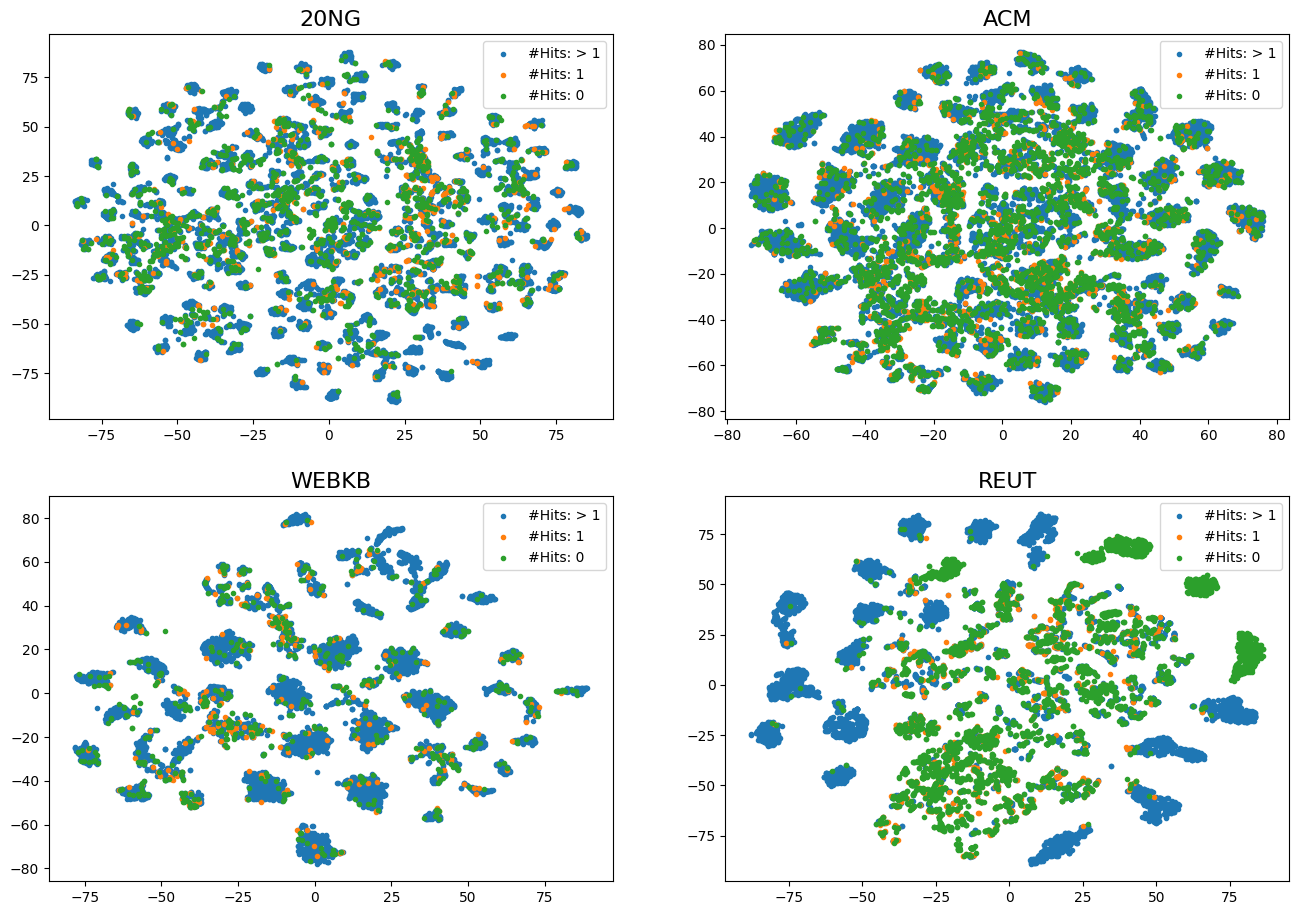

In [26]:
plt.figure(figsize=(16,11))
for pidx, dset in enumerate(DATASETS):
    hits = hits_agree[dset].copy()
    hits[hits > 1] = 2
    plt.subplot(2, 2, pidx+1)
    scatter_plot(d_tsne[dset], hits)
    plt.title(dset.upper(), fontsize=16)

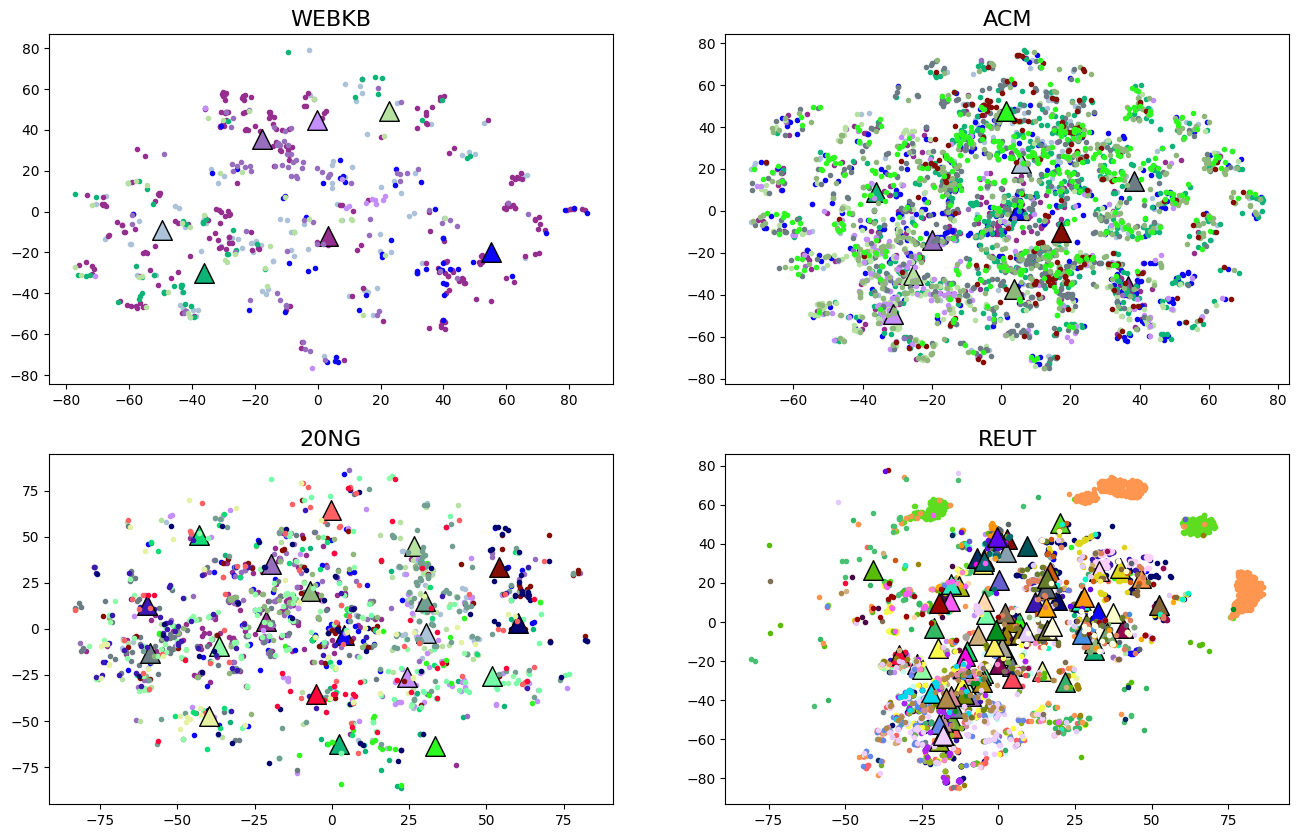

In [29]:
color_list = [ c for c in matplotlib.colors.get_named_colors_mapping() ]

plt.figure(figsize=(16,10))
for pidx, dset in enumerate(["webkb", "acm", "20ng", "reut"]):
    
    tsne_embs = d_tsne[dset]
    df = pd_datasets[dset]
    y_true = df.classes.values
    labels = np.unique(y_true)
    x_cent, y_cent = [], []
    for label, color_id in zip(labels, range(0, len(color_list), 9)):
        x, y = np.mean(tsne_embs[y_true == label], axis=0)
        x_cent.append(x)
        y_cent.append(y)
        plt.subplot(2, 2, pidx + 1)
        hits = hits_agree[dset]
        c1 = y_true == label
        c2 = hits == 0
        points = tsne_embs[np.logical_and(c1, c2)]
        plt.scatter(points[:, 0], points[:, 1], color=color_list[color_id], marker=".")
        plt.scatter([x], [y], [200], color=color_list[color_id], marker="^", edgecolors="black")

    plt.title(dset.upper(), fontsize=16)

In [30]:
_ = """
for dset in DATASETS:
    with open(f"/home/claudiovaliense/projetos/kaggle/dataset/{dset}/splits/split_10_with_val.pkl", 'rb') as fd:
        claudio = pickle.load(fd)
        chrstian = pd.read_pickle(f"/home/christian/arquivado/projeto_stacking/input/{dset}/representations/10_folds_splits.csv")
        for ch, cl in zip(chrstian.test_idxs.values, claudio.test_idxs.values):
            print(set(np.equal(ch, cl)))
"""

# Quais classificadores mais acertaram onde o BERT errou?

(2647,)
(5479,)
(1145,)
(5661,)


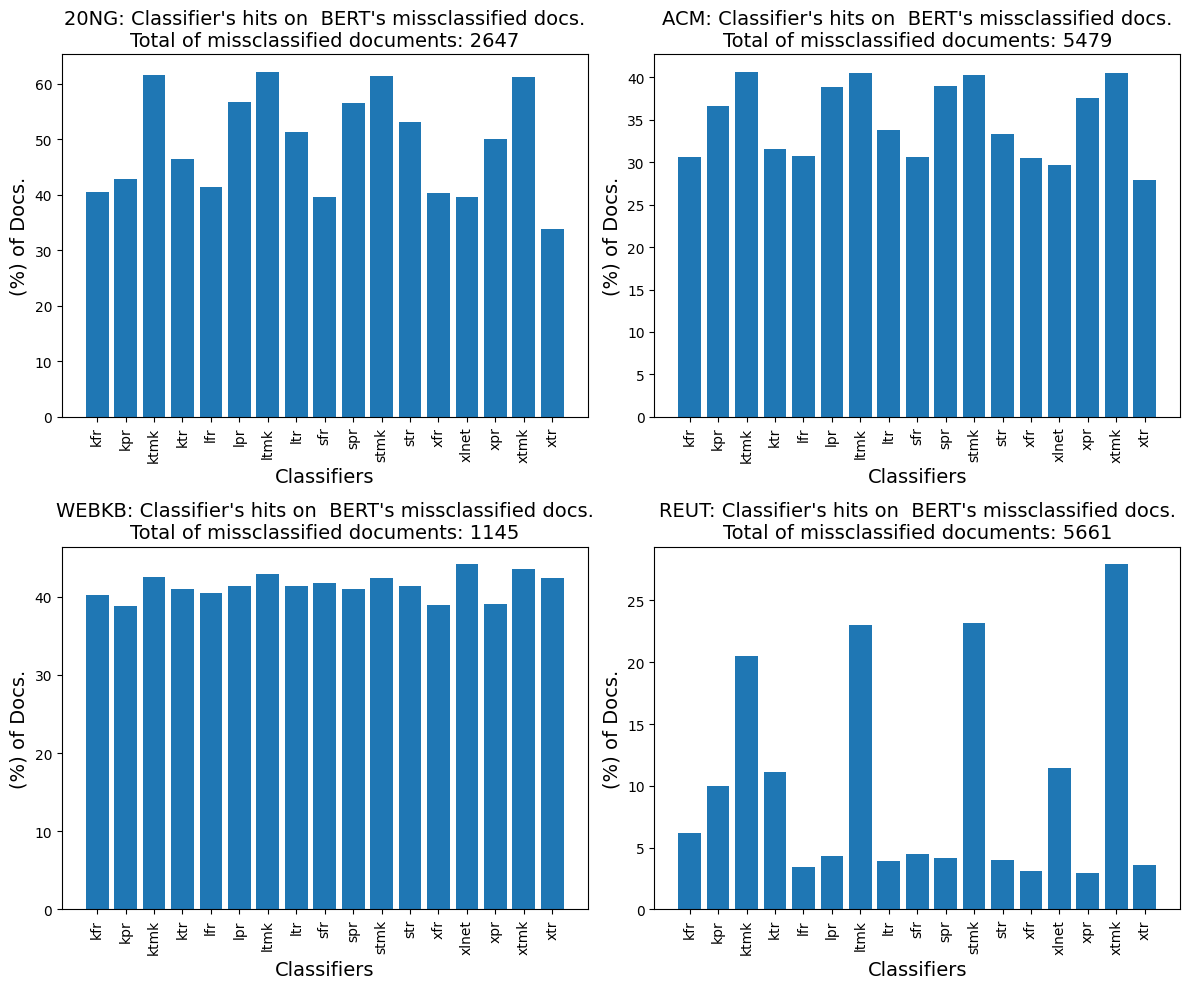

In [55]:
plt.figure(figsize=(12, 10))
for pidx, dset in enumerate(DATASETS):
    df = pd_datasets[dset]
    # Selecionando as colunas com as predições.
    pred_cols = [ col for col in df.columns if col.find("y_pred") > -1 ]
    # Coluna com as predições do BERT.
    bert_preds = df.bert_y_pred.values
    # Columna com as predições dos demais classificadores
    clfs_preds = df[pred_cols].drop(columns=["bert_y_pred"]).values
    # Y true.
    y_true = df.classes.values
    # Selecionando os índices dos documentos onde o BERT errou.
    bert_misses = bert_preds != y_true
    # Selecionando as predições dos demais classificadores onde o BERT errou.
    partial_clfs = clfs_preds[bert_misses]
    # Selecionando o y true onde o BERT errou.
    partial_y = y_true[bert_misses]
    print(partial_y.shape)
    # Comparando o y true com as predições dos demais classificadores.
    hits = partial_clfs == partial_y[:, None]
    # Somando o total de acerto por classificador.
    y_clfs = np.sum(hits, axis=0)
    xticks = [ col.replace("_y_pred", '') for col in df[pred_cols].drop(columns=["bert_y_pred"]).columns ]

    x = np.arange(len(xticks))
    plt.subplot(2, 2, pidx + 1)
    plt.bar(x, (y_clfs / partial_y.shape[0]) * 100)
    plt.title(f"{dset.upper()}: Classifier's hits on  BERT's missclassified docs.\nTotal of missclassified documents: {partial_y.shape[0]}", fontsize=14)
    plt.xticks(ticks=x, labels=xticks, rotation=90)
    plt.ylabel("(%) of Docs.", fontsize=14)
    plt.xlabel("Classifiers", fontsize=14)

plt.tight_layout()

# Quais classificadores acertam mais sozinhos

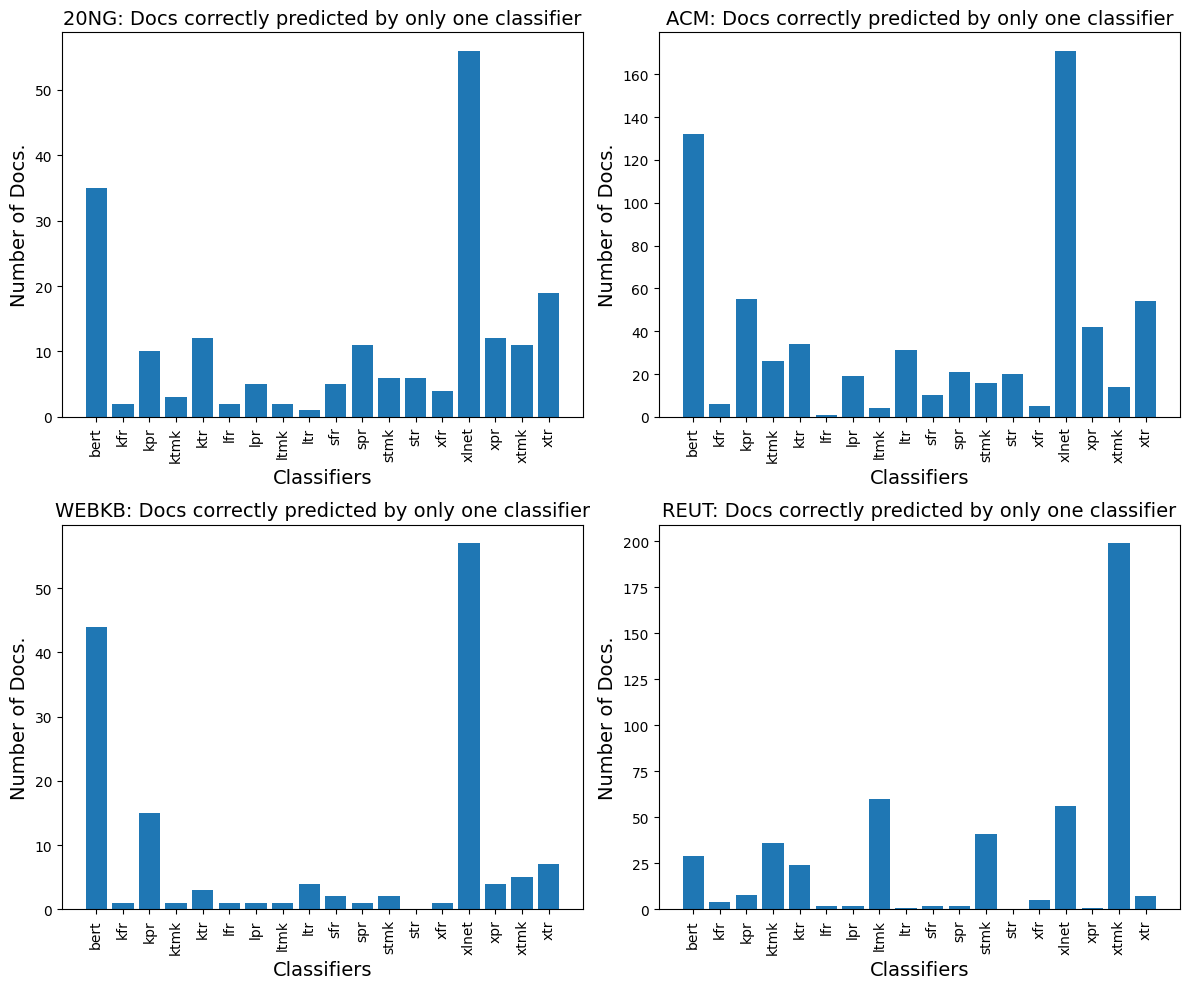

In [60]:
plt.figure(figsize=(12, 10))
for pidx, dset in enumerate(DATASETS):
    df = pd_datasets[dset]
    # Selecionando as colunas com as predições.
    pred_cols = [ col for col in df.columns if col.find("y_pred") > -1 ]
    # Coluna com as predições do BERT.
    clfs_preds = df[pred_cols].values
    y_true = df.classes.values

    hits = clfs_preds == y_true[:, None]
    only_one = np.sum(hits, axis=1) == 1

    y_clfs = np.sum(hits[only_one], axis=0)
    xticks = [ col.replace("_y_pred", '') for col in df[pred_cols].columns ]

    x = np.arange(len(xticks))
    
    plt.subplot(2, 2, pidx + 1)
    plt.bar(x, y_clfs)
    plt.title(f"{dset.upper()}: Docs correctly predicted by only one classifier", fontsize=14)
    plt.xticks(ticks=x, labels=xticks, rotation=90)
    plt.ylabel("Number of Docs.", fontsize=14)
    plt.xlabel("Classifiers", fontsize=14)

plt.tight_layout()

In [56]:
m = np.array([[1,1], [1,2], [2,1]])
n = np.array([1,1,1])

In [57]:
m == n[:, None]

array([[ True,  True],
       [ True, False],
       [False,  True]])